In [73]:
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import binom
from scipy.stats import beta

warnings.filterwarnings( 'ignore' )

# Bayesian A/B testing

Suppose you want to run an A/B/n test on your website's landing page and randomly (evenly) assign each user to a variation:
- Control - the current version of the website with an orange button
- Variation A - updates the button color to blue
- Variation B - updates the button color to red

You know that the control has a conversion rate of about .05 (i.e. 5%) with a variance of about .025, thus conversions rage from .025 to .075. You think that one of the variations may increase the mean conversion rate by 1-2%.

You want to calculate your findings on a daily basis until you feel like you have enough evidence to make a decision on which variation performs the best.

## Methodology

Let's look at all the key assumptions you need to consider and the calculations you'll need to make each time you want to update your results. 

### Parameters of Interest

The main parameters you'll want to consider are the conversion rates for each variation. Let's call these:
- $\theta_{c}$ - The true probability that a user will convert on the control
- $\theta_{a}$ - The true probability that a user will convert on variation a
- $\theta_{b}$ - The true probability that a user will convert on variation b

### Likelihood

Because an A/B test can be considered a binomial experiment, you can use a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) for the likelihood.

The binomial distribution is discrete, but if you plot enough data points we can see that is starts looking a lot like a normal distribution. 

Here is a binomial distribution with a $.2$ probability.

The two plots show the same distribution, but the first plot generates the distribution using random samples, the second one calculates values within a range.

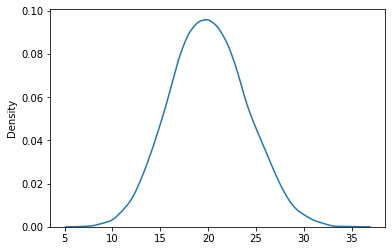

In [42]:
# https://www.w3schools.com/python/numpy_random_binomial.asp
sns.distplot(random.binomial(n=100, p=0.2, size=10000), hist=False, label='binomial')
plt.show()

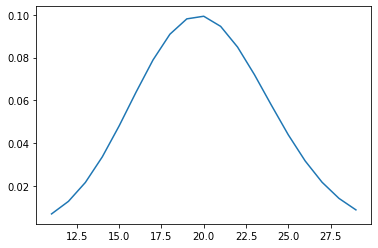

In [29]:
from scipy.stats import binom

n =  100
p = .2
# x = np.linspace( binom.ppf(0.01, n, p), binom.ppf(0.99, n, p), 20 )
x = np.arange(start=binom.ppf(0.01, n, p),
              stop=binom.ppf(0.99, n, p),
              step=1)
y = binom.pmf(x,n,p)
plt.plot(x,y)
plt.show()

### Priors

The [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for a binomial likelihood is a Beta prior. That means that if you use a Beta prior, you will also get a Beta posterior. We'll talk about this more when we discuss the posterior distribution.

The Beta distribution is continuous and has an $\alpha$ and $\beta$ parameter. It is quite a versatile distribution as the magnitude and ratio of $\alpha$ and $\beta$ can give the distribution quite a few different shapes. 

Here is a Beta distribution with $\alpha=2$ and $\beta=2$. 

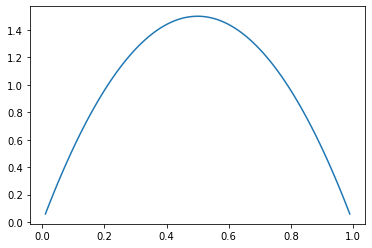

In [22]:
a = 2
b = 2
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

Here is a Beta distribution with $\alpha=1$ and $\beta=1$. When used as a prior, this is often called an *uninformative prior* because all parameter values have the same probability.

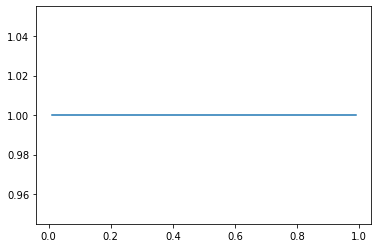

In [31]:
a = 1
b = 1
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

### Prior Probabilities

Regardless of what the initial prior probability distribution (informative or uninformative) you decide to use, if you have enough samples (trials) in your experiment, you will converge on the same posterior distribution.

However, the benefit of having an informative prior is that you can get to a meaningful result with fewer samples. That means that you can decide on a winner and end your experiment faster. In turn, that means that you can run more experiments, gain more revenue, or provide a better experience to your users faster.

Assuming you want to use an informative prior, you can select $\alpha$ and $\beta$ parameters (called *hyperparameters*) to give you a prior distribution for theta by leveraging what you know about your conversion rates. 

When selecting the prior, you can use your knowledge about the existing website conversion rate. Since you know your current website conversion is .05 with a variance of 0.025, a good prior might be centered on .05 and have the majority of its density between 0.025 to 0.075:
- $\theta > 0.025$ - Much of the probability mass should be above this
- $\theta > 0.05$ - About 1/2 of our mass should be above this
- $\theta > 0.075$ - Little of the probability mass should be above this

The Beta distribution has a nice feature that allows you to create a distribution that centers around a number by merely using a ratio of $\frac{ \alpha }{ \beta }$ that equals that number. 

For example, if you go with $\alpha=50$ and $\beta=1000$ it centers on .05.

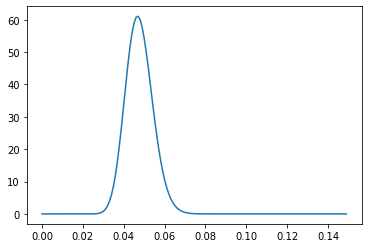

In [36]:
a = 50
b = 1000
x = np.arange (0.0, .15, 0.001)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

That looks good, but let's check it by calculating the probability of this distriution when $\theta$ is above 0.025, 0.05, and 0.075.

In [39]:
cdf1 = 1 - beta.cdf(x=0.025,a=50,b=1000)
cdf2 = 1 - beta.cdf(x=0.05,a=50,b=1000)
cdf3 = 1 - beta.cdf(x=0.075,a=50,b=1000)
print("Using hyperparameters a=50 and b=1000:")
print("theta > 0.025 =", cdf1)
print("theta > 0.05 =", cdf2)
print("theta > 0.075 =", cdf3)

Using hyperparameters a=50 and b=1000:
theta > 0.025 = 0.9999822993237697
theta > 0.05 = 0.344509822991683
theta > 0.075 = 0.00013888834085984403


Not too bad! Most of the probability is within the range you want, and the center at 3.4% is a bit off but not too much.

What if you go with smaller hyperparameters like $\alpha=5$ and $\beta=100$?

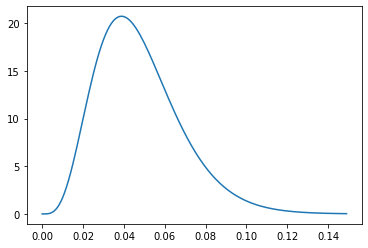

In [38]:
a = 5
b = 100
x = np.arange (0.0, .15, 0.001)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

It looks like those hyperparameters approximately maintained the 5% ratio, but notice there is a bit of a right skew now. That's because the Beta distribution has a skew when you use smaller hyperparameter values.

Let's check out the probabilities:

In [40]:
cdf1 = 1 - beta.cdf(x=0.025,a=5,b=100)
cdf2 = 1 - beta.cdf(x=0.05,a=5,b=100)
cdf3 = 1 - beta.cdf(x=0.075,a=5,b=100)
print("Using hyperparameters a=5 and b=100:")
print("theta > 0.025 =", cdf1)
print("theta > 0.05 =", cdf2)
print("theta > 0.075 =", cdf3)

Using hyperparameters a=5 and b=100:
theta > 0.025 = 0.8799481139650547
theta > 0.05 = 0.400941014049089
theta > 0.075 = 0.10251341976351447


That actually has a slightly more centered distribution, but there is now a bit more density above and below the variance range. That might be ok because it is a little broader so your prior will inform your outcome a little less when your sample size is small. Also, since you're expecting that one of your variations will increase your conversion rate, your posterior might shift things higher anyways.

Using even smaller hyperparameters of $\alpha=1$ and $\beta=20$ to maintain the 5% ratio, changes the shape of the Beta distribution altogether.

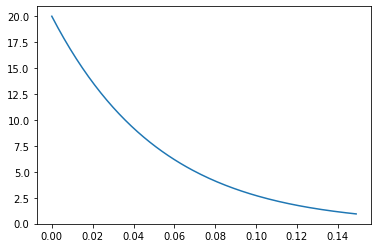

In [39]:
a = 1
b = 20
x = np.arange (0.0, .15, 0.001)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

This is actually one of the strengths of the Beta distribution in that using just the two parameters you can make it take many different forms. The tradeoff, however is that it gets a little tricker to have a normal (i.e. gaussian) looking distribution when you're working with smaller parameter values.

Let's look at the theta probabilites for these hyperparameters.

In [41]:
cdf1 = 1 - beta.cdf(x=0.025,a=1,b=20)
cdf2 = 1 - beta.cdf(x=0.05,a=1,b=20)
cdf3 = 1 - beta.cdf(x=0.075,a=1,b=20)
print("Using hyperparameters a=1 and b=20:")
print("theta > 0.025 =", cdf1)
print("theta > 0.05 =", cdf2)
print("theta > 0.075 =", cdf3)

Using hyperparameters a=1 and b=20:
theta > 0.025 = 0.6026876802191005
theta > 0.05 = 0.35848592240854227
theta > 0.075 = 0.21029776386659416


This is quite different than the previous distributions because it is now giving you about 40% of your probability density under 0.025, which is mostly out of the range you'd expect given the variance of your current conversion rate. 

But, the fact that it is keeping the majority of your density under 0.075 is still mostly informing the upper end of your expected range.

The nice thing about the Bayesian model is that sequential and cumulative analysis will produce the same results. So, it's quite easy to just try out a different prior distribution at any point in your A/B test to see if it has any impact.

For the purposes of this example, we'll continue with an uninformative Beta prior with $\alpha=1$ and $\beta=1$.

### Posterior Distribution

Because you're using a Beta distribution as a prior, you'll also get a Beta distribution for your posterior.

You can think of the $\alpha$ and $\beta$ values as representing successes and failures, respectively. So:

$$Beta( \alpha=\text{ successes }, \beta=\text{ failures } )$$

As you get more evidence, you merely need to update your $\alpha$ and $\beta$ values. You'll add your new evidence (new success and failure counts) to your prior evidence (previously measured success and failure counts).

So, calculating the posterior distribution is quite simple. Skipping all the theory, all you need to do is calculate your new $\alpha$ and $\beta$ parameters using the following rules and plug them back in to the Beta distribution:

$$Beta( a = a_{\text{posterior}}, b = b_{\text{posterior}} )$$

Where
* $a_{\text{posterior}}$ = $a_{\text{prior}}$ + successes
* $b_{\text{posterior}}$ = $b_{\text{prior}}$ + trials - successes

For example let's say you're using a prior of:

$Beta( \alpha=5, \beta=100 )$

Then after a day, let's say one of your variations gets 11 successes (i.e. conversions) out of 150 trials.

The posterior distribution would be:

$Beta( \alpha=5+11, \beta=100+150-11 )$

So the posterior probability of your conversion rate for this variation would look like this:

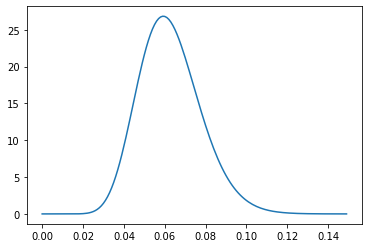

In [43]:
a = 5+11
b = 100+150-11
x = np.arange (0.0, .15, 0.001)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

It looks like the posterior is approximately centered at 0.06. You can calculate the Posterior Mean and Maximum Likelihiood Estimate, which are both quite easy for a Beta distribution.

Posterior Mean:
$$\frac{\alpha}{\alpha+\beta}$$

Maximum Likelihood Estimate (MLE):
$$\frac{\text{successes}}{\text{trials}}$$

In [54]:
a = 5+11
b = 100+150-11
m = a / ( a + b )
s = 11
n = 150
mle = s / n
print( "Posterior Mean:", m )
print( "Maximum Likelihood Estimate:", mle )

Posterior Mean: 0.06274509803921569
Maximum Likelihood Estimate: 0.07333333333333333


You can also calculate the equal tail 95% credible interval to see where most of the probability lies:

In [48]:
lower = beta.ppf(q=0.025,a=5+11,b=100+150-11,loc=0,scale=1)
upper = beta.ppf(q=0.975,a=5+11,b=100+150-11,loc=0,scale=1)

print( "Equal tail 95% credible interval" )
print( "Lower bound:", lower )
print( "Upper bound:", upper )

Equal tail 95% credible interval
Lower bound: 0.036430755230848884
Upper bound: 0.0955326947180638


So, with one day of data, it is 95% likely that the conversion rate for Variation A is between 3.6% and 9.5%. Of course, the more data you get the tighter the range will get.

Let see what would happen if you got another day's worth of data. This time you got 8 successes (i.e. conversions) out of 142 trials.

You can calculate the new posterior probability for day two in one of two ways:
* sum up the total cumulative success across all days and rerun the calculation against the original prior
* use the $\alpha$ and $\beta$ values from your previous day as your new prior and plug in your incremental trails and successes for day two

Both methods will give you the same result, but let's use the second method. Your previous day's posterior alpha and beta were:
* $a = 5 + 11 = 16$
* $b = 100 + 150 - 11 = 239$

Now you can use those as the prior when calculating the posterior for day two:

Beta( a=16+8, b=239+142-8 )

So the updated posterior results are:

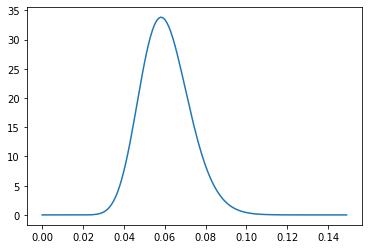

In [49]:
a = 16+8
b = 239+142-8
x = np.arange (0.0, .15, 0.001)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()

In [57]:
a = 16+8
b = 239+142-8
m = a / ( a + b )
s = 11+8
n = 150+142
mle = s / n
print( "Posterior Mean:", m )
print( "Maximum Likelihood Estimate:", mle )

lower = beta.ppf(q=0.025,a=a,b=b,loc=0,scale=1)
upper = beta.ppf(q=0.975,a=a,b=b,loc=0,scale=1)

print()
print( "Equal tail 95% credible interval" )
print( "Lower bound:", lower )
print( "Upper bound:", upper )

Posterior Mean: 0.060453400503778336
Maximum Likelihood Estimate: 0.06506849315068493

Equal tail 95% credible interval
Lower bound: 0.039213758324120405
Upper bound: 0.08587772466322774


As you can see the shape of the updated posterior distribution is quite similar, but the width has tightened and the height has increased slightly. The most evidence you collect, the more your probability range will narrow.

### Comparing Variations

You now know how to select a prior distribution and how to calculate the posterior distribution, posterior mean, and posterior Maximum Likelihood Estimate.

But how do you know which variation won?

You can do this mathematically and get a precise answer, but the equations and even the code can get a [little complex](https://www.evanmiller.org/bayesian-ab-testing.html).

The easier way is to use a [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) or sampling method where you take a large number of random samples from the posterior distribution of each variation and see which one is selected the most often.

Let's take 200,000 random samples from each of three distributions and see which one has the highest probability of winning:

In [299]:
# https://stackoverflow.com/questions/55062928/how-to-compare-3-numpy-arrays-elementwise-and-get-the-results-as-the-array-with


def print_winner( control, variation_a, variation_b ):
    max = np.argmax( ( control, variation_a, variation_b ), 0)
    (unique, counts) = np.unique(max, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    # print( frequencies )

    # names = np.array(['variation_%d'%(i+1) for i in range(3)])
    # names[np.argmax((variation_1,variation_2,variation_3),0)]

    print( "Probability of winning:")
    print( "Control:", frequencies[0][1] / n )
    print( "Variation A:", ( frequencies[1][1] / n ) if ( len( frequencies ) > 1 ) else 0  )
    print( "Variation B:", ( frequencies[2][1] / n ) if ( len( frequencies ) > 2 ) else 0  )



control_a = 70
control_b = 1000
variation_a_a = 60
variation_a_b = 1000
variation_b_a = 50
variation_b_b = 1000

n=200000

control=beta.rvs(size=n,a=control_a,b=control_b,loc=0,scale=1)
variation_a=beta.rvs(size=n,a=variation_a_a,b=variation_a_b,loc=0,scale=1)
variation_b=beta.rvs(size=n,a=variation_b_a,b=variation_b_b,loc=0,scale=1)

print_winner( control, variation_a, variation_b )

Probability of winning:
Control: 0.78652
Variation A: 0.19141
Variation B: 0.02207


### Value at Risk

You may have a conversion rate threshold under which you aren't willing to go. Similar to how we compared the variations, you can take samples from your distribution and compare them to your threshold to find a probability of going under that threshold.

Let's say one of your variations has have a posterior $\alpha=500$ and $\beta=10000$ (a ratio of 5%) and you want to find out what the Value at Risk of being below 4.4%. 


In [396]:
# https://youtu.be/UxEFAkDlkiA?t=2033
n=200000
threshold=.044

samples=beta.rvs(size=n,a=500,b=10000,loc=0,scale=1)
value_at_risk = np.mean( samples < threshold )
print("Probability that conversion rate is less than 4.4%:", value_at_risk )

Probability that conversion rate is less than 4.4%: 0.037985


## Calculating Results

OK, so you start running your test. Let's calculate your conversion metrics. 

In [395]:
import pandas as pd

days = 100
trials_per_day = 150
variance = .01

control_success_rate = .05
variation_a_success_rate = .06
variation_b_success_rate = .04


def generate_success_array( success_rate ):
    return np.random.normal( success_rate * trials_per_day, variance * trials_per_day, days).round()

def generate_trials_array():
    return np.random.normal( 150, 10, days).round()

d = { 
    'Control Successes':     generate_success_array( control_success_rate ), 
    'Control Trials':        generate_trials_array(),
    'Variation A Successes': generate_success_array( variation_a_success_rate ), 
    'Variation A Trials':    generate_trials_array(),
    'Variation B Successes': generate_success_array( variation_b_success_rate ), 
    'Variation B Trials':    generate_trials_array(),
}
experiment_data = pd.DataFrame( d )
experiment_data

,Control Successes,Control Trials,Variation A Successes,Variation A Trials,Variation B Successes,Variation B Trials
0,9.0,152.0,10.0,160.0,7.0,142.0
1,4.0,161.0,7.0,153.0,5.0,147.0
2,6.0,152.0,9.0,131.0,6.0,171.0
3,5.0,149.0,11.0,142.0,4.0,156.0
4,8.0,150.0,9.0,152.0,8.0,165.0
...,...,...,...,...,...,...
95,9.0,148.0,11.0,143.0,7.0,148.0
96,4.0,149.0,11.0,166.0,4.0,136.0
97,7.0,152.0,10.0,144.0,6.0,142.0
98,6.0,146.0,7.0,152.0,9.0,141.0


We're randomly generating normally distributed trials counts for each variation, centered around 150 / day. 

We're randomly generating normally distributed trials counts for each variation, centered around:
- Control - 5%
- Variation A - 6%
- Variation B - 4%

Of course, you wouldn't know this information up front in a real A/B test, but here we can use that information to evaluate which prior distributions will lead us to an answer faster.

In [381]:
def plot_beta( a, b ):
    x = np.arange (0.0, .15, 0.001)
    y = beta.pdf(x, a=post_a, b=post_b)
    plt.plot(x,y)
    plt.show()

class Variation:
    def __init__( self, name, prior_a, prior_b ):
        self._name = name
        self._prior_a = prior_a
        self._prior_b = prior_b
        self._posterior_a = 0
        self._posterior_b = 0
        self._trials = 0
        self._successes = 0
    
    def add_trials( self, successes, trials ):
        self._trials = self._trials + trials
        self._successes = self._successes + successes
        
        self._posterior_a = self.prior_a() + self._successes
        self._posterior_b = self.prior_b() + self._trials - self._successes
            
    def name( self ):
        return self._name
    
    def prior_a( self ):
        return self._prior_a

    def prior_b( self ):
        return self._prior_b
    
    def posterior_a( self ):
        return self._posterior_a

    def posterior_b( self ):
        return self._posterior_b

    def maximum_likelihood_estimate( self ):
        return self._successes / self._trials

    def posterior_mean( self ):
        return self._posterior_a / ( self._posterior_a + self._posterior_b )

    def credible_interval( self ):
        lower = beta.ppf( q=0.025, a=self.posterior_a(), b=self.posterior_b(), loc=0, scale=1 )
        upper = beta.ppf( q=0.975, a=self.posterior_a(), b=self.posterior_b(), loc=0, scale=1 )
        return ( lower, upper )

    def print_summary( self ):
        print( "----", self.name(), "----")
        print( "Posterior alpha:", self.posterior_a() )
        print( "Posterior beta:", self.posterior_b() )
        print( "Posterior Mean: %2.3f" % self.posterior_mean() )
        print( "Maximum Likelihood Estimate: %2.3f" % self.maximum_likelihood_estimate() )

        ( lower, upper ) = self.credible_interval()

        print()
        print( "Equal tail 95% credible interval" )
        print( "Lower bound: %2.3f" % lower )
        print( "Upper bound: %2.3f" % upper )

        plot_beta( post_a, post_b )
    
    def sample_from_posterior( self, sample_count ):
        return beta.rvs(
            size=sample_count, 
            a=self.posterior_a(), 
            b=self.posterior_b(), 
            loc=0, 
            scale=1
        )

class Experiment:
    def __init__( self, experiment_data, initial_prior_a, initial_prior_b ):
        self._data = experiment_data
        self._day = -1
        self._control = Variation( 'Control', initial_prior_a, initial_prior_b )
        self._variation_a = Variation( "Variation A", initial_prior_a, initial_prior_b )
        self._variation_b = Variation( "Variation B", initial_prior_a, initial_prior_b )

    def next_day( self ):
        self._day = self._day + 1
        self._control.add_trials( self.control_successes(), self.control_trials() )
        self._variation_a.add_trials( self.variation_a_successes(), self.variation_a_trials() )
        self._variation_b.add_trials( self.variation_b_successes(), self.variation_b_trials() )

    def fetch_cell( self, name ):
        return self._data[ self._day : self._day + 1 ].at[ self._day, name ]
        
    def control_successes( self ):
        return self.fetch_cell( 'Control Successes' )

    def control_trials( self ):
        return self.fetch_cell( 'Control Trials' )
    
    def variation_a_successes( self ):
        return self.fetch_cell( 'Variation A Successes' )

    def variation_a_trials( self ):
        return self.fetch_cell( 'Variation A Trials' )
    
    def variation_b_successes( self ):
        return self.fetch_cell( 'Variation B Successes' )

    def variation_b_trials( self ):
        return self.fetch_cell( 'Variation B Trials' )
    
    def print_winner( self ):
        
        n = 200000
        control_samples = self._control.sample_from_posterior( n )
        variation_a_samples = self._variation_a.sample_from_posterior( n )
        variation_b_samples = self._variation_b.sample_from_posterior( n )
        
        max = np.argmax( ( control_samples, variation_a_samples, variation_b_samples ), 0)
        (unique, counts) = np.unique(max, return_counts=True)
        frequencies = np.asarray((unique, counts)).T

        print( '- - - - - - - - - - - - - - - - - - - - - - - - - -')
        print( "Probability of winning on day", self._day + 1 )
        print()
        print( "Control:", frequencies[0][1] / n )
        print( "Variation A:", ( frequencies[1][1] / n ) if ( len( frequencies ) > 1 ) else 0  )
        print( "Variation B:", ( frequencies[2][1] / n ) if ( len( frequencies ) > 2 ) else 0  )
        print( '- - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    def print_summary( self ):
        print( '- - - - - - - - - - - - - - - - - - - - - - - - - -' )
        print( "Results for day", self._day + 1 )
        print()
        self._control.print_summary()
        self._variation_a.print_summary()
        self._variation_b.print_summary()
        
initial_prior_a = 1
initial_prior_b = 1
control = Variation( 'Control', initial_prior_a, initial_prior_b )
variation_a = Variation( "Variation A", initial_prior_a, initial_prior_b )
variation_b = Variation( "Variation B", initial_prior_a, initial_prior_b )

experiment = Experiment( experiment_data, 1, 1 )

### Day 1

After you collect the first day's data, you can run through the analysis outlined above to see what each variaiton looks like and which one is most likely to be the winner.

Here we're using an uninformative prior. 

- - - - - - - - - - - - - - - - - - - - - - - - - -
Results for day 1

---- Control ----
Posterior alpha: 7.0
Posterior beta: 136.0
Posterior Mean: 0.049
Maximum Likelihood Estimate: 0.043

Equal tail 95% credible interval
Lower bound: 0.020
Upper bound: 0.090


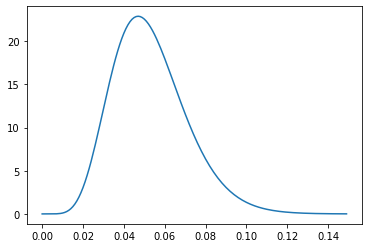

---- Variation A ----
Posterior alpha: 8.0
Posterior beta: 143.0
Posterior Mean: 0.053
Maximum Likelihood Estimate: 0.047

Equal tail 95% credible interval
Lower bound: 0.023
Upper bound: 0.094


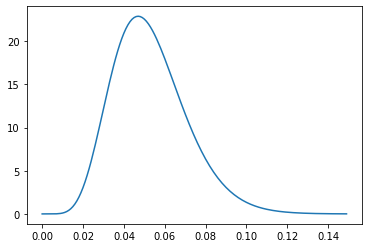

---- Variation B ----
Posterior alpha: 8.0
Posterior beta: 147.0
Posterior Mean: 0.052
Maximum Likelihood Estimate: 0.046

Equal tail 95% credible interval
Lower bound: 0.023
Upper bound: 0.091


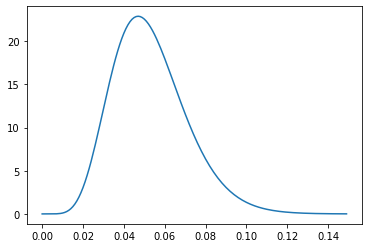

- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 1

Control: 0.28426
Variation A: 0.375475
Variation B: 0.340265
- - - - - - - - - - - - - - - - - - - - - - - - - -


In [382]:
experiment.next_day()
experiment.print_summary()
experiment.print_winner()

Wow! After just the first day, it looks like Variation A (which you happen know is the best performing variation) is performing far better than the others.

But you should almost always let A/B tests last at least a week to avoid fluctuations in behavior based on the day of week. So let's see what the data looks as we move forward. 

### Day 2

- - - - - - - - - - - - - - - - - - - - - - - - - -
Results for day 2

---- Control ----
Posterior alpha: 14.0
Posterior beta: 273.0
Posterior Mean: 0.049
Maximum Likelihood Estimate: 0.046

Equal tail 95% credible interval
Lower bound: 0.027
Upper bound: 0.076


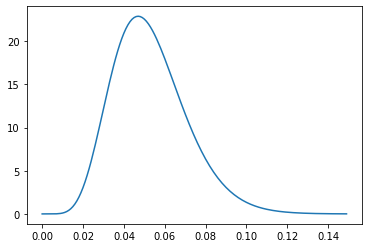

---- Variation A ----
Posterior alpha: 17.0
Posterior beta: 292.0
Posterior Mean: 0.055
Maximum Likelihood Estimate: 0.052

Equal tail 95% credible interval
Lower bound: 0.032
Upper bound: 0.083


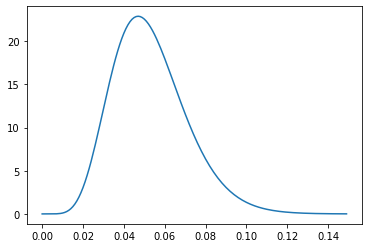

---- Variation B ----
Posterior alpha: 13.0
Posterior beta: 287.0
Posterior Mean: 0.043
Maximum Likelihood Estimate: 0.040

Equal tail 95% credible interval
Lower bound: 0.023
Upper bound: 0.069


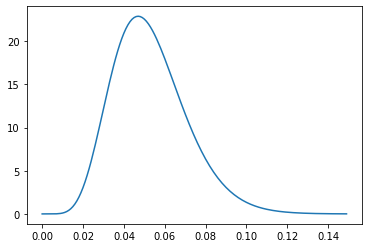

- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 2

Control: 0.30047
Variation A: 0.539065
Variation B: 0.160465
- - - - - - - - - - - - - - - - - - - - - - - - - -


In [383]:
experiment.next_day()
experiment.print_summary()
experiment.print_winner()

### Day 3

- - - - - - - - - - - - - - - - - - - - - - - - - -
Results for day 3

---- Control ----
Posterior alpha: 24.0
Posterior beta: 410.0
Posterior Mean: 0.055
Maximum Likelihood Estimate: 0.053

Equal tail 95% credible interval
Lower bound: 0.036
Upper bound: 0.079


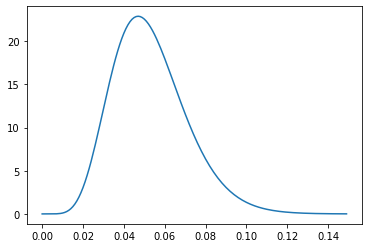

---- Variation A ----
Posterior alpha: 27.0
Posterior beta: 447.0
Posterior Mean: 0.057
Maximum Likelihood Estimate: 0.055

Equal tail 95% credible interval
Lower bound: 0.038
Upper bound: 0.080


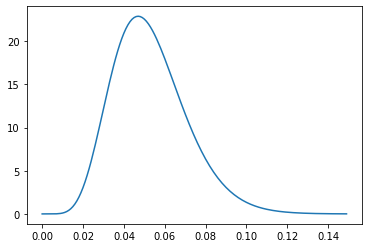

---- Variation B ----
Posterior alpha: 18.0
Posterior beta: 424.0
Posterior Mean: 0.041
Maximum Likelihood Estimate: 0.039

Equal tail 95% credible interval
Lower bound: 0.024
Upper bound: 0.061


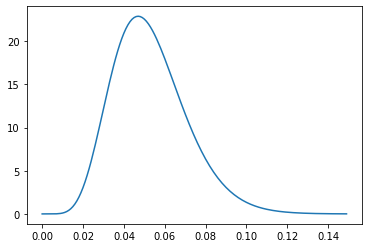

- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 3

Control: 0.43103
Variation A: 0.51597
Variation B: 0.053
- - - - - - - - - - - - - - - - - - - - - - - - - -


In [384]:
experiment.next_day()
experiment.print_summary()
experiment.print_winner()

### Remaining days


In [385]:
import builtins
range = builtins.range

for n in range( 0, 97 ):
    experiment.next_day()
    # experiment.print_summary()
    experiment.print_winner()

- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 4

Control: 0.33127
Variation A: 0.50952
Variation B: 0.15921
- - - - - - - - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 5

Control: 0.234515
Variation A: 0.64844
Variation B: 0.117045
- - - - - - - - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 6

Control: 0.132615
Variation A: 0.808745
Variation B: 0.05864
- - - - - - - - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 7

Control: 0.07701
Variation A: 0.895715
Variation B: 0.027275
- - - - - - - - - - - - - - - - - - - - - - - - - -
- - - - - - - - - - - - - - - - - - - - - - - - - -
Probability of winning on day 8

Control: 0.07968
Variation A: 0.90761
Variation B: 0.01271
- - - - - - - - - - - - - - - - - - - - - - - - - -
- - - - - - - 